In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print('Torch version:', torch.__version__)

Torch version: 2.7.0+cu126


In [53]:
import clip

print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [54]:
model_name = 'ViT-B/16'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load(model_name, device=device)
print('Model loaded:', model_name)
print('Device:', device)
print('Preprocess function:', preprocess)

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(f'Model parameters: {np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}')
print(f'Input resolution: {input_resolution}')
print(f'Context length: {context_length}')
print(f'Vocab size: {vocab_size}')
print(f'Preprocess function: {preprocess}')

Model loaded: ViT-B/16
Device: cuda
Preprocess function: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7cc1c4f43060>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408
Preprocess function: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7cc1c4f43060>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [55]:
tokens = clip.tokenize('Hello, world!')
print('Tokens:', tokens)
print('Tokens shape:', tokens.shape)

Tokens: tensor([[49406,  3306,   267,  1002,   256, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)
Tokens shape: torch.Size([1, 77])


Image directory: /home/vmoskov/CLIP-CarDetector/images
Number of images: 5


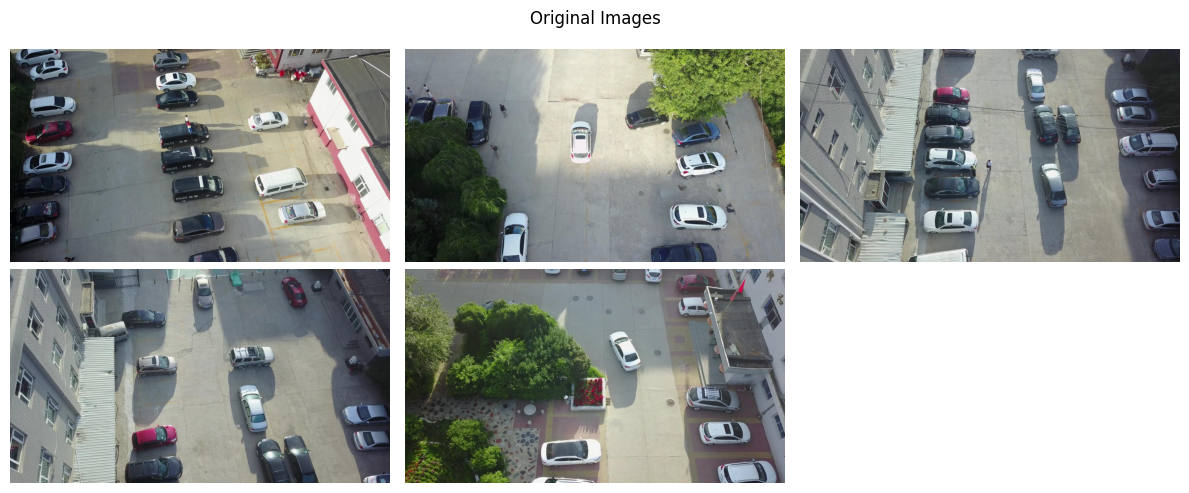

In [56]:
from pathlib import Path
from PIL import Image

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)  # suppress matplotlib clipping warnings for better readability

img_dir = Path(Path.cwd() / 'images')
print('Image directory:', img_dir)

# load images
img_paths = list(img_dir.glob('*.jpg'))
print(f'Number of images: {len(img_paths)}')

original_images = []
images = []

for img_path in img_paths:
    image = Image.open(img_path)
    original_images.append(image)
    # turn to tensor and append to list
    images.append(torch.tensor(np.array(image)).permute(2, 0, 1))

# show original images
plt.figure(figsize=(12, 5))
plt.suptitle('Original Images')
for i, img in enumerate(original_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

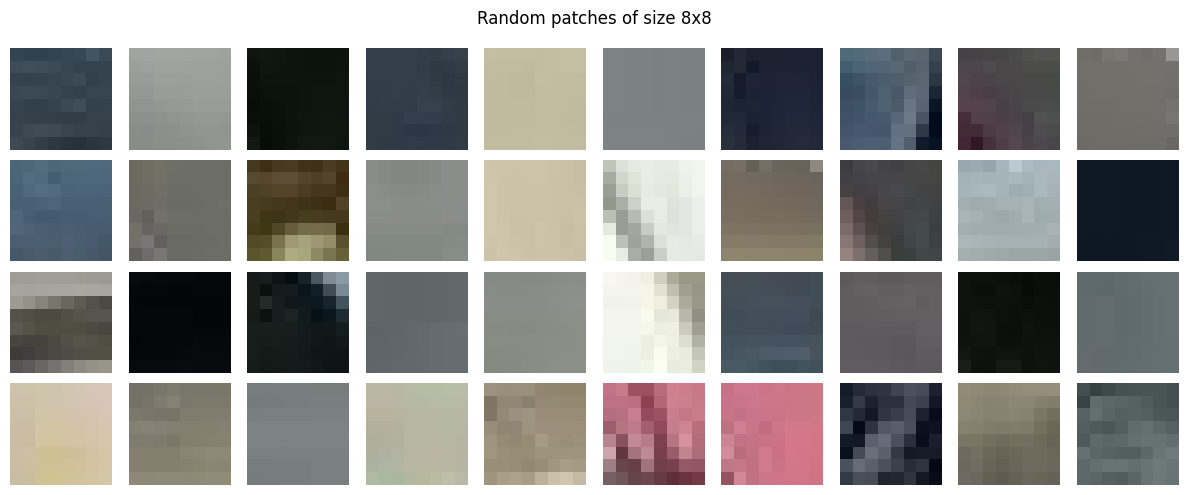

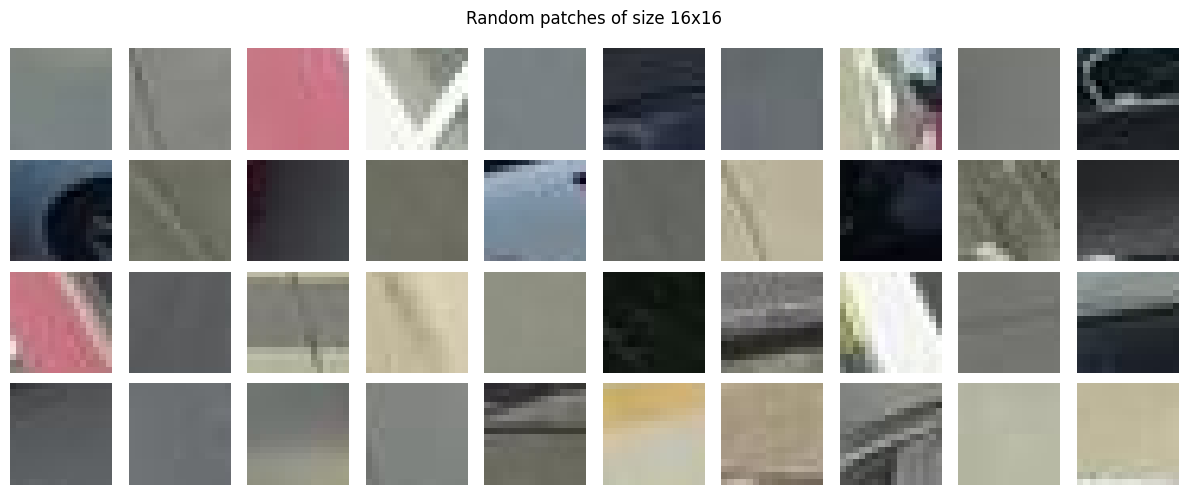

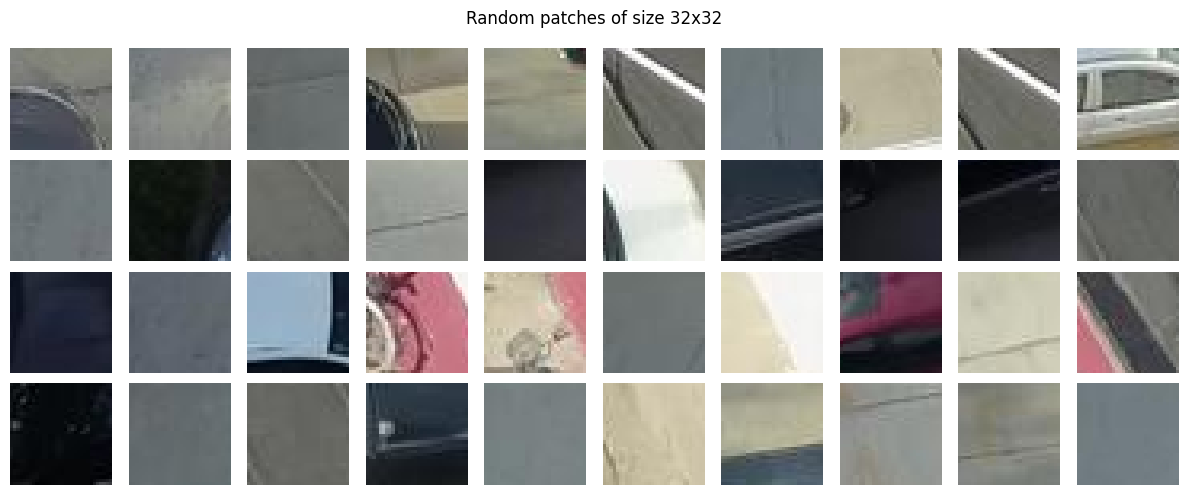

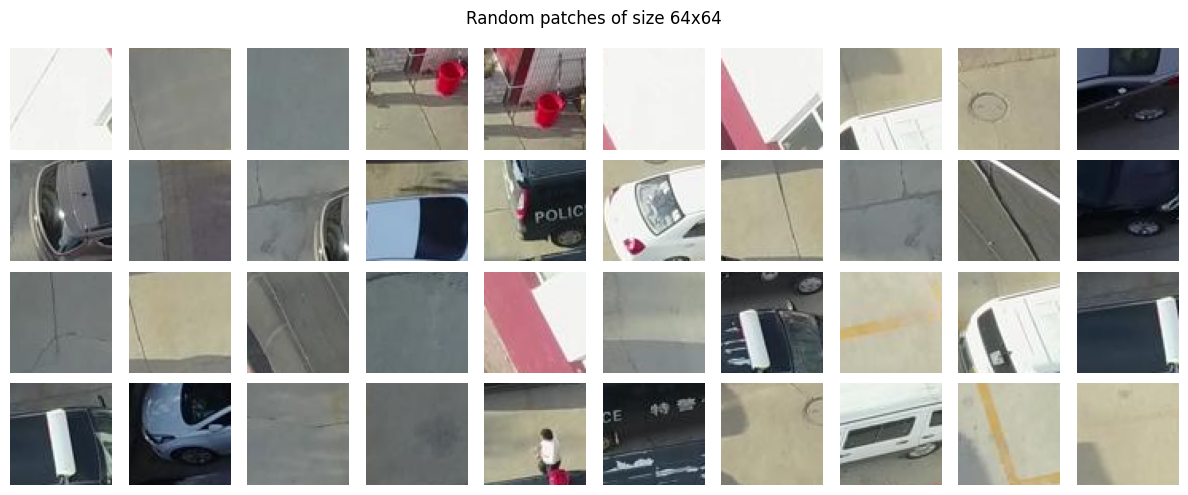

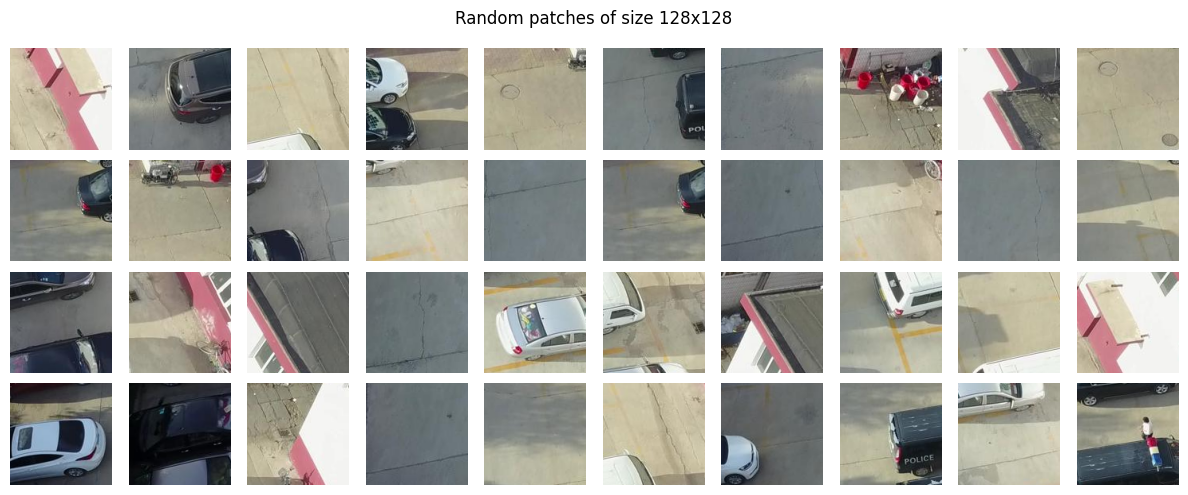

In [57]:
# test with different patch sizes
# only on first image
img = images[0]
for patch_size in [8, 16, 32, 64, 128]:
    # show 40 random patches
    patches = []
    for _ in range(40):
        x = np.random.randint(0, img.shape[1] - patch_size)
        y = np.random.randint(0, img.shape[2] - patch_size)
        patch = img[:, x:x + patch_size, y:y + patch_size]
        patches.append(patch)
    patches = torch.stack(patches)
    patches = patches.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Random patches of size {patch_size}x{patch_size}')
    for i, patch in enumerate(patches):
        plt.subplot(4, 10, i + 1)
        plt.imshow(patch)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Patches with sizes 128x128 and 64x64 are definitely too large for car detection, since they contain too much background information. Furthermore, patches with sizes 32x32 capture almost the entire car, which is not ideal for training a detector since we want to slide the window over the image taking multiple patches at once into consideration to have a finer granulation of the image. It could be useful to detect cars on a bigger scale. We fall back to the order of magintude of 16x16 patches.

Patches shape: torch.Size([1, 45, 80, 3, 17, 17])
Batch patches shape: torch.Size([5, 45, 80, 3, 17, 17])


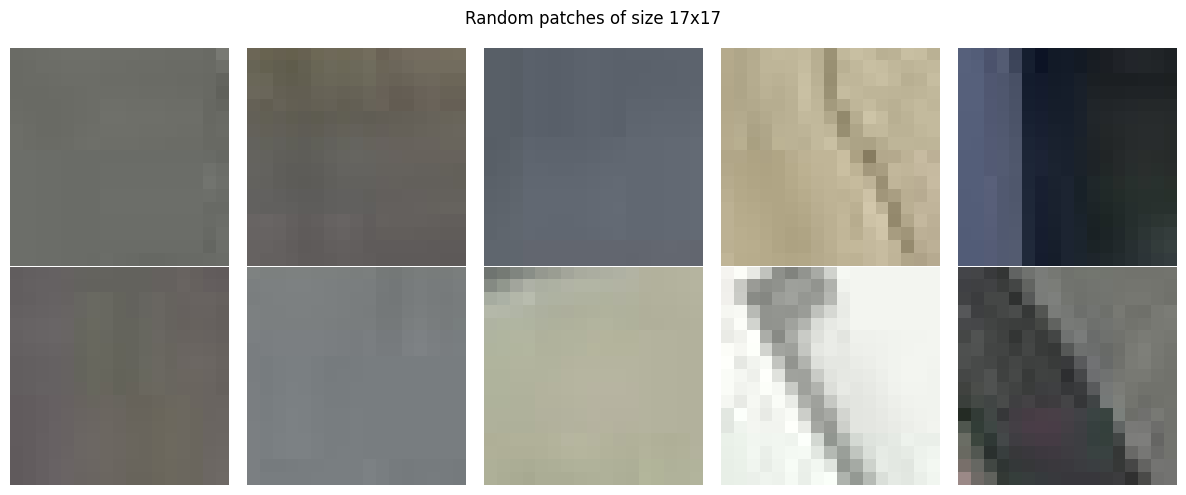

In [58]:
import einops

image_inputs = torch.stack(images).to(device)

# test the model on the first image only
img = image_inputs[0]

# patchify the image
def patchify(x, patch_size):
    '''
    Patchify an image tensor of shape (B, C, H, W) into patches of size (patch_size, patch_size).
    Args:
        x: image tensor of shape (B, C, H, W)
        patch_size: size of the patches
    Returns:
        x: tensor of shape (B, num_patches_h, num_patches_w, C, patch_size, patch_size)
    '''
    x = einops.rearrange(x, 'b c h w -> b h w c')
    # unfold
    x = x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    return x


patch_size = 17
patches = patchify(img.unsqueeze(0), patch_size)
print('Patches shape:', patches.shape)

batch_patches = patchify(image_inputs, patch_size)
print('Batch patches shape:', batch_patches.shape)

# show 10 random patches
plt.figure(figsize=(12, 5))
plt.suptitle(f'Random patches of size {patch_size}x{patch_size}')
for i in range(10):
    x = np.random.randint(0, patches.shape[1] - 1)
    y = np.random.randint(0, patches.shape[2] - 1)
    plt.subplot(2, 5, i + 1)
    plt.imshow(patches[0, x, y].permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [59]:
classes = ['car']
text_input = clip.tokenize([f'a photo of a {c}' for c in classes]).to(device)


def get_scores(patches, prompts, window_size, stride):
    '''
    Get scores for each patch in the image.
    Args:
        patches: tensor of shape (B, num_patches_h, num_patches_w, C, patch_size, patch_size)
        prompts: tensor of shape (num_prompts, context_length)
        window_size: size of the window to slide over the image
        stride: stride of the sliding window
    Returns:
        scores: tensor of shape (num_patches_h, num_patches_w)
    '''
    b, num_patches_h, num_patches_w, c, h, w = patches.shape

    scores = torch.zeros(b, num_patches_h, num_patches_w).to(device)
    runs = torch.ones(b, num_patches_h, num_patches_w).to(device)

    for Y in range(0, num_patches_h - window_size + 1, stride):  # slide top to bottom
        for X in range(0, num_patches_w - window_size + 1, stride):  # slide left to right
            # window = torch.zeros(b, patch_size * window_size, patch_size * window_size, 3, dtype=torch.int32)
            patch_pool = patches[:, Y:Y + window_size, X:X + window_size]
            
            window = einops.rearrange(
                patch_pool,
                'b ws1 ws2 c ph pw -> b (ws1 ph) (ws2 pw) c'
            ).to(torch.uint8)
            
            # read window to PIL image
            # window = Image.fromarray(window.numpy().astype(np.uint8))
            pil_windows = [preprocess(Image.fromarray(w.cpu().numpy().astype(np.uint8))) for w in window]
            batch_windows = torch.stack(pil_windows).to(device)
            # convert to PIL image
            # window = preprocess(window).unsqueeze(0).to(device)  # preprocess window
            with torch.no_grad():
                logits_per_image, logits_per_text = model(batch_windows, prompts)
                batch_scores = logits_per_image

            scores[:, Y:Y + window_size, X:X + window_size] += batch_scores[:, None]
            runs[:, Y:Y + window_size, X:X + window_size] += 1
    
    # normalize scores
    scores /= runs
    for _ in range(3):  # suppress low scores
        scores = scores - scores.mean(dim=(1, 2), keepdim=True)
        scores = torch.clamp(scores, torch.tensor(0.0, device=scores.device), scores.amax(dim=(1, 2), keepdim=True))
    scores = (scores - scores.amin(dim=(1, 2), keepdim=True)) / (scores.amax(dim=(1, 2), keepdim=True) - scores.amin(dim=(1, 2), keepdim=True) + 1e-8)

    return scores


window_size = 3
stride = 1
scores = get_scores(batch_patches, text_input, window_size, stride)

print('Scores shape:', scores.shape)
print('Patches shape:', batch_patches.shape)


Scores shape: torch.Size([5, 45, 80])
Patches shape: torch.Size([5, 45, 80, 3, 17, 17])


In [60]:
# adjusted_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1)
adjusted_patches = einops.rearrange(
    batch_patches,
    'b num_patches_h num_patches_w c ph pw -> ph pw c b num_patches_h num_patches_w'
)
print('Adjusted patches shape:', adjusted_patches.shape)

Adjusted patches shape: torch.Size([17, 17, 3, 5, 45, 80])


In [61]:
adjusted_patches = adjusted_patches.to(torch.float32)
adjusted_patches *= scores
adjusted_patches = adjusted_patches.to(torch.int32)

adjusted_patches = einops.rearrange(
    adjusted_patches,
    'ph pw c b num_patches_h num_patches_w -> b num_patches_h num_patches_w c ph pw'
)
# adjusted_patches = adjusted_patches.permute(3, 4, 2, 0, 1)  # rotate patches to visualize
print('Adjusted patches shape:', adjusted_patches.shape)

Adjusted patches shape: torch.Size([5, 45, 80, 3, 17, 17])


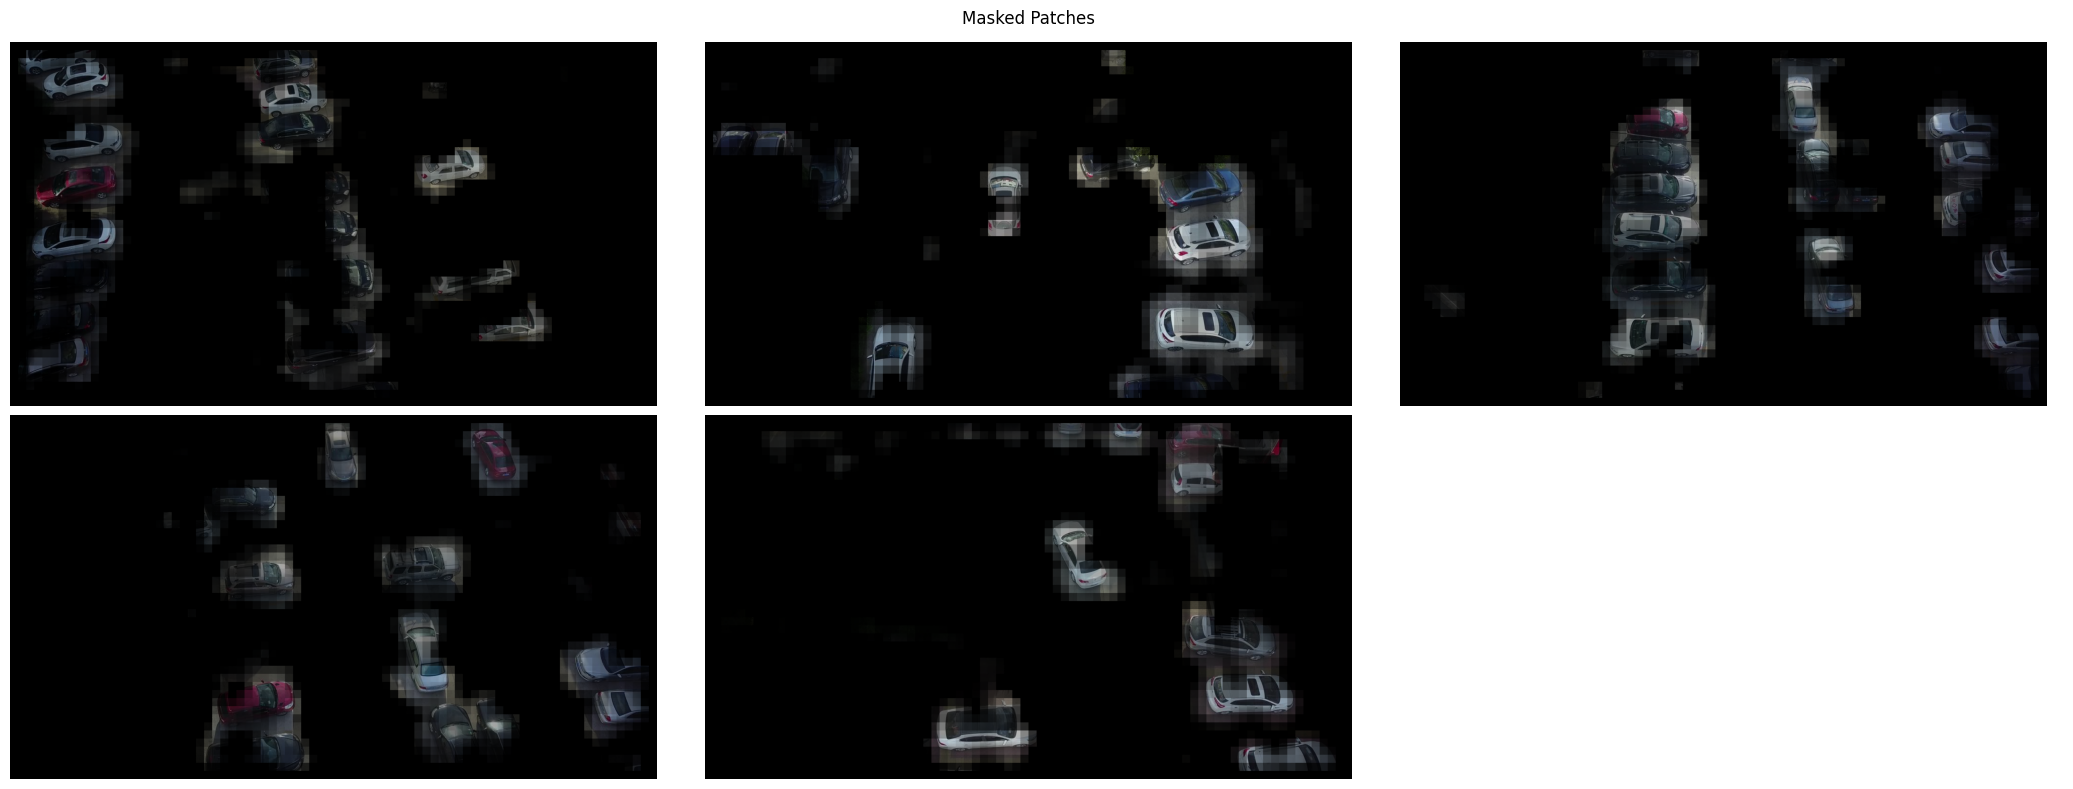

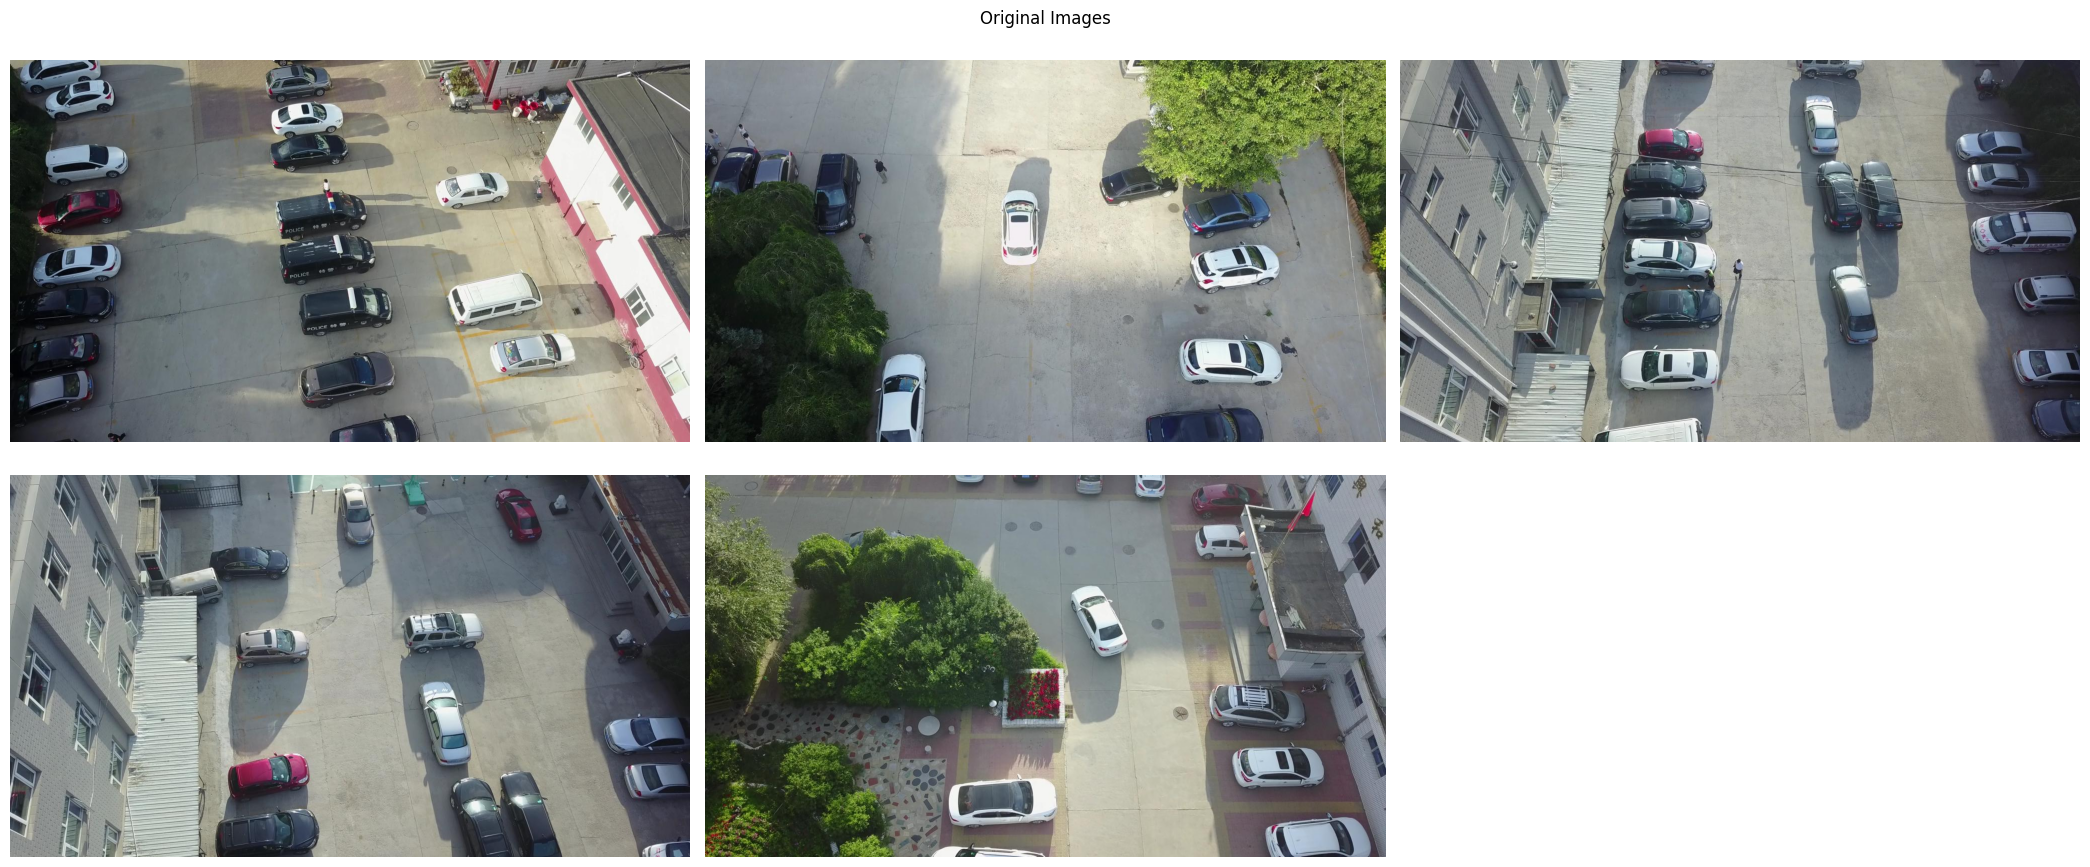

In [67]:
b, num_patches_h, num_patches_w, c, ph, pw = adjusted_patches.shape

def visualize_adjusted_patches(adjusted_patches):
    b, num_patches_h, num_patches_w, c, ph, pw = adjusted_patches.shape
    images = []

    for i in range(b):
        image = torch.zeros(num_patches_h * ph, num_patches_w * pw, c)
        for y in range(num_patches_h):
            for x in range(num_patches_w):
                patch = adjusted_patches[i, y, x].permute(1, 2, 0)  # (ph, pw, c)
                image[y*ph:(y+1)*ph, x*pw:(x+1)*pw] = patch
        images.append(image)

    cols = 3
    rows = (b + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 4))
    fig.suptitle('Masked Patches', fontsize=12)
    axes = np.array(axes).reshape(rows, cols)

    for idx, img in enumerate(images):
        ax = axes[idx // cols, idx % cols]
        ax.imshow(img.cpu().numpy().astype(np.uint8))
        ax.axis("off")
        ax.set_aspect('equal')

    # Turn off any unused axes
    for i in range(rows * cols):
        if i >= b:
            axes[i // cols, i % cols].axis("off")

    plt.tight_layout()
    plt.show()


visualize_adjusted_patches(adjusted_patches)

# show original images
plt.figure(figsize=(21, 9))
plt.suptitle('Original Images')
for i, img in enumerate(original_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()